# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID: 20    
TEAM-NAME: formula-ai
YOUR-ID: 2018122003
YOUR-NAME: Krishna Kumar Maram

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
import numpy as np

# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [2]:
##############################################################################
# TODO: Code for Section 1
def motionModel(x,u):
    return x+u

def infoMat(x1):
    return jnp.linalg.inv(jnp.cov(x))

def residual(x,u):
    x_list=list(x)
    x_list2=x_list[:-1]+[x_list[0]]
    x_list3=x_list[1:]+[x_list[4]] + [0]
    x_mod1=jnp.array(x_list2)
    x_mod2=jnp.array(x_list3)
    est=motionModel(x_mod1,u)
    xListEst=list(est)
    x_list4=xListEst+[x_list[0]]
    x_modEst=jnp.array(x_list4)
    
    return x_modEst-x_mod2

#residual calculation
f=lambda x_r: residual(x_r,uob)

#Confidence Matrix with assumed 
cov=jnp.dot(0.01,
          jnp.identity(6))
cov=jax.ops.index_update(cov,jax.ops.index[5,5],0.001)
omega=jnp.linalg.inv(cov)


#Objective Function
F=lambda x: jnp.dot(
  jnp.dot(jnp.transpose(f(x)),omega),
  f(x))

/home/krishna/anaconda3/envs/mr_assignment1/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
def gaussNewton(k_p,learningRate,tolerance,maxIterations):
    alpha=learningRate #learning rate
    max_iterations=maxIterations
    tolerance=tolerance
    res_vec=f(k_p)
    r_val=jnp.dot(jnp.transpose(res_vec),res_vec)
    del_r=jnp.array([[1.0,-1.0,0.0,0.0,0.0],
                   [0.0,1.0,-1.0,0.0,0.0],
                   [0.0,0.0,1.0,-1.0,0.0],
                   [0.0,0.0,0.0,1.0,-1.0],
                   [1.0,0.0,0.0,0.0,-1.0],
                   [1.0,0.0,0.0,0.0,0.0]])
    
    #jacobian calculation
#     j=jacfwd(f)
#     print(j(k_p))
    
    #Hessian matrix calucalation
    H=jnp.dot(
        jnp.dot(jnp.transpose(del_r),omega),
        del_r)
#     print(H)
        
    def direction():
        
        term1=jnp.linalg.inv(H)
        term2=-jnp.dot(
            jnp.dot(jnp.transpose(del_r),jnp.transpose(omega)),
            f(k_p))
        term3=jnp.dot(term1,term2)
        return term3
    
    
    k_p=k_p+alpha*direction()
    
    itr=0
    while(itr<maxIterations and r_val>=tolerance):
        k_p=k_p+alpha*direction()
        if(itr==0):
            print('Estimate after first iteration of Gauss Newton=',k_p)
        if(itr==3):
            print('Estimate afte second iteration of Gauss Newton=',k_p)
        res_vec=f(k_p)
        r_val=jnp.dot(jnp.transpose(res_vec),res_vec)
        itr+=1  
    return k_p

In [4]:
#Ground Truth
ugt=jnp.array([1,1,1,-3.0])
xgt=jnp.array([0,1,2,3,0])

#Observed values 
uob=jnp.array([1.1,1.0,1.1,-2.7,0.0])
xob=jnp.array([0.0,1.1,2.1,3.2,0.5])

#initial residual
# print(F(xob))

#Optimization using Gauss Newton
alpha=1
tol=10^-5
maxIterations=200
x_opt=gaussNewton(xob,alpha,tol,maxIterations) #Estimate
print('The estimate after optimization=',x_opt)
# print(F(x_opt))

Estimate after first iteration of Gauss Newton= [-3.5762282e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]
Estimate afte second iteration of Gauss Newton= [-3.2782785e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]
The estimate after optimization= [-3.2782707e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

In [5]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'b->')

    plt.show()
def draw3(X1, Y1, THETA1, X2,Y2,THETA2,X3,Y3,THETA3,save=False,name='result'):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'bo',label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'b->')
    
    ax.plot(X2, Y2, 'go',label='Init')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'g->')
    
    ax.plot(X3, Y3, 'mo',label='Optimized')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'm->')
    plt.legend()
    plt.show()
    if save==True:
        plt.savefig('plot_'+name+'.png')

In [6]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
file = open('dataset/edges.txt',"r")
data = file.readlines()
index_i,index_j,del_x,del_y,del_theta = readEdge('dataset/edges.txt')
vertices = readVertex('dataset/edges.txt')
gt_vertices = readVertex('dataset/gt.txt')
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

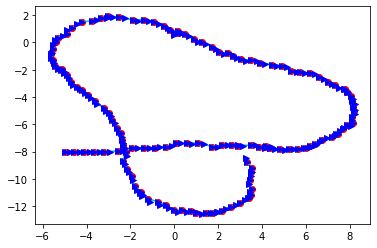

In [7]:
position = [vertices]
for c in range(index_i.shape[0]):
    i,j = index_i[c],index_j[c]
    if i+1 != j:
        break
    old_x,old_y,old_theta = position[i]
    diff = jnp.array([del_x[i],del_y[i]]).reshape(2,1)
    old = jnp.array([old_x,old_y]).reshape(2,1)
    angles = jnp.array([[jnp.cos(old_theta),-jnp.sin(old_theta)],[jnp.sin(old_theta),jnp.cos(old_theta)]]).reshape(2,2)
    new = old + angles@diff
    new_x,new_y = new
    new_theta = old_theta + del_theta[i]
    new_pos = jnp.array([new_x,new_y,new_theta])
    position.append(new_pos)
pos = jnp.array(position)
init_X,init_Y,init_THETA = pos[:,0],pos[:,1],pos[:,2]
gt_X,gt_Y,gt_THETA = gt_vertices
draw(init_X,init_Y,init_THETA)

In [8]:
edges = []
for d in data:
    if 'VERTEX' in d:
        vertex.append(d)
    if 'EDGE' in d:
        edges.append(d)
edges.append('FIX 0\n')
def write_vertex(position):
    vertex = []
    for i,pos in enumerate(position):
        x,y,theta = pos
        n_vertex = []
        n_vertex.append('VERTEX_SE2')
        n_vertex.append(str(i+1))
        n_vertex.append(str(x[0]))
        n_vertex.append(str(y[0]))
        n_vertex.append(str(theta[0]))
        vertex_string = " ".join(n_vertex)
        vertex_string+= '\n'
        vertex.append(vertex_string)
    return vertex
vert = write_vertex(position)

NameError: name 'vertex' is not defined

In [ ]:
with open('edges-poses.g2o','w') as filehandle:
    filehandle.writelines("%s" % v for v in vert)
    filehandle.writelines("%s" % e for e in edges)

In [ ]:
def calc_pos_x(old_x,del_x,del_y,old_theta):
    return old_x+del_x*jnp.cos(old_theta) - del_y*jnp.sin(old_theta)
def calc_pos_y(old_y,del_x,del_y,old_theta):
    return old_y+del_y*jnp.cos(old_theta) + del_x*jnp.sin(old_theta)
def calc_pos_theta(old_theta,del_theta):
    return old_theta+del_theta
orig_x,orig_y,orig_theta = vertices
def residual(Vec,index_i,index_j,del_x,del_y,del_theta):
    X,Y,THETA = Vec[:,0],Vec[:,1],Vec[:,2]
    f = []
    for ind in range(index_i.shape[0]):
        i,j = index_i[ind],index_j[ind]
        x_col = calc_pos_x(X[i],del_x[i],del_y[i],THETA[i]) - X[j]
        y_col = calc_pos_y(Y[i],del_x[i],del_y[i],THETA[i]) - Y[j]
        theta_col = calc_pos_theta(THETA[i],del_theta[i]) - THETA[j]
        col = jnp.array([x_col,y_col,theta_col])
        f.append(col)
    col = jnp.array([X[0]-orig_x,Y[0]-orig_y,THETA[0]-orig_theta])
    f.append(col)
    f = jnp.array(f).flatten('F')
    return f

In [ ]:
def create_info(odometry,loop,fixed):
    information = []
    for ind in range(index_i.shape[0]):
        i,j = index_i[ind],index_j[ind]
        if i+1 == j:
            information.append(odometry)
        else:
            information.append(loop)
    information.append(fixed)
    information = information*3
    info = jnp.array(information)
    info_matrix = jnp.diag(info)
    return info_matrix

In [ ]:
f_=lambda vector : residual(vector,index_i,index_j,del_x,del_y,del_theta)
def total_error(residual,info_matrix):
    return 0.5*residual.T@info_matrix@residual

In [ ]:
# x w.r.t everything
from jax.ops import index, index_add, index_update
def manual_jacobian(X,Y,THETA):
    x_deriv = []
    for ind in range(index_i.shape[0]):
        i,j = index_i[ind],index_j[ind]
        deriv_x = jnp.zeros([360])
        deriv_x = index_update(deriv_x,index[i],1)
        deriv_x = index_update(deriv_x,index[j],-1)
        theta_update = -del_x[i]*jnp.sin(THETA[i]) - del_y[i]*jnp.cos(THETA[i])
        deriv_x = index_update(deriv_x,index[240+i],float(theta_update))
        x_deriv.append(deriv_x)
    deriv_x = jnp.zeros([360])
    deriv_x = index_update(deriv_x,index[0],1)
    x_deriv.append(deriv_x)
    x_deriv = jnp.array(x_deriv)

    #y w.r.t everything
    y_deriv = []
    for ind in range(index_i.shape[0]):
        i,j = index_i[ind],index_j[ind]
        deriv_y = jnp.zeros([360])
        deriv_y = index_update(deriv_y,index[120+i],1)
        deriv_y = index_update(deriv_y,index[120+j],-1)
        theta_update = -del_y[i]*jnp.sin(THETA[i]) + del_x[i]*jnp.cos(THETA[i])
        deriv_y = index_update(deriv_y,index[240+i],float(theta_update))
        y_deriv.append(deriv_y)
    deriv_y = jnp.zeros([360])
    deriv_y = index_update(deriv_y,index[120],1)
    y_deriv.append(deriv_y)
    y_deriv = jnp.array(y_deriv)

    #theta w.r.t everything
    theta_deriv = []
    for ind in range(index_i.shape[0]):
        i,j = index_i[ind],index_j[ind]
        deriv_theta = jnp.zeros([360])
        deriv_theta = index_update(deriv_theta,index[240+i],1)
        deriv_theta = index_update(deriv_theta,index[240+j],-1)
        theta_deriv.append(deriv_theta)
    deriv_theta = jnp.zeros([360])
    deriv_theta = index_update(deriv_theta,index[240],1)
    theta_deriv.append(deriv_theta)
    theta_deriv = jnp.array(theta_deriv)

    #concatinating them together
    m_j = jnp.vstack((x_deriv,y_deriv,theta_deriv))
    return m_j

In [ ]:
def cal_jacobian(f_,posi):
    j=jacfwd(f_)
    jacobian = j(posi)
    k = []
    for i in range(420):
        k.append(jacobian[i].flatten('F'))
    jac = jnp.array(k)
    return jac

In [ ]:
inp_pos = jnp.array(position)
m_jac = manual_jacobian(inp_pos[:,1],inp_pos[:,2],inp_pos[:,3])
jac = cal_jacobian(f_,inp_pos)

In [ ]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
frobNorm(jac,m_jac,"Jax Jacobian","Manual Jacobian")

In [ ]:
def direction(jac,info_matrix,residual):
    H = jac.T@info_matrix@jac
    b = jac.T@info_matrix.T@residual
    update_vec = jnp.linalg.inv(H)@b
    return update_vec

In [ ]:
def save_poses(pos,name):
    n_vert = write_vertex(pos)
    n_vert.append('FIX 0\n')
    with open(name+'.g2o','w') as filehandle:
        filehandle.writelines("%s" % v for v in n_vert)

In [ ]:
def optimize(X,Y,THETA,info_matrix,save=False,name='result'):
    errors = []
    for i in range(30):
        position_matrix = jnp.hstack([X,Y,THETA]).reshape(120,3,1)
        residual_vector = f_(position_matrix)
        jac = cal_jacobian(f_,position_matrix)
        error = total_error(residual_vector,info_matrix)
        errors.append(error)
        print("Iteration : %d, Error : %f" % (i,float(error)))
        if i%5 == 0:
            draw3(gt_X,gt_Y,gt_THETA,init_X,init_Y,init_THETA,X,Y,THETA)
        if error < 40:
            break
        update_vec = direction(jac,info_matrix,residual_vector)
        X -= update_vec[:120].reshape(120,1)
        Y -= update_vec[120:240].reshape(120,1)
        THETA -= update_vec[240:360].reshape(120,1)
    if save:
        draw3(gt_X,gt_Y,gt_THETA,init_X,init_Y,init_THETA,X,Y,THETA,save,name)
    else:
        draw3(gt_X,gt_Y,gt_THETA,init_X,init_Y,init_THETA,X,Y,THETA)
    new_pos = np.hstack([X,Y,THETA]).reshape(120,3,1)
    return new_pos,errors

In [ ]:
info_matrix = create_info(500.0,700.0,1000.0)
new_pos,e = optimize(init_X,init_Y,init_THETA,info_matrix)
save_poses(new_pos,'opt')

In [ ]:
info_matrix = create_info(100.0,1000.0,1000.0)
new_pos,e = optimize(init_X,init_Y,init_THETA,info_matrix)
save_poses(new_pos,'opt_100_1000')

In [ ]:
info_matrix = create_info(10.0,1000.0,1000.0)
new_pos,e = optimize(init_X,init_Y,init_THETA,info_matrix)
save_poses(new_pos,'opt_10_1000')

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

## Observations
We observe that error was governed by the confidence we had in odometry constraints. Reducing it had significant impact on overall error. However, we are not able to get a better map in any case which can be highlighted by plots from EVO
1) Odometry - 500, Loop - 700  
RPE
![](misc/rpe.png)  
APE
![](misc/ape.png)  
XYZ losses  
![](misc/trajec_xyz.png)
Rotation Diff
![](misc/trajec_rpy.png)
2) Odometry - 100, Loop - 1000  
RPE
![](misc/rpe_1000.png)  
APE
![](misc/ape_100.png)  
XYZ losses  
![](misc/trajec_xyz_100.png)
Rotation Diff
![](misc/trajec_rpy_100.png)
3) Odometry - 10, Loop - 1000  
RPE
![](misc/rpe_10.png)  
APE
![](misc/ape_10.png)  
XYZ losses  
![](misc/trajec_xyz_10.png)
Rotation Diff
![](misc/trajec_rpy_10.png)



## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

#### Optimization of Edges.

(i) Generated the poses for edges.g20. 

(ii). Loaded edges.g2o on g2o and optimized it for 50 itertaions. 
Using gn_var_cholmod.using spanning tree.  

(iii) Experimented with other optimizers, but gave the same result.

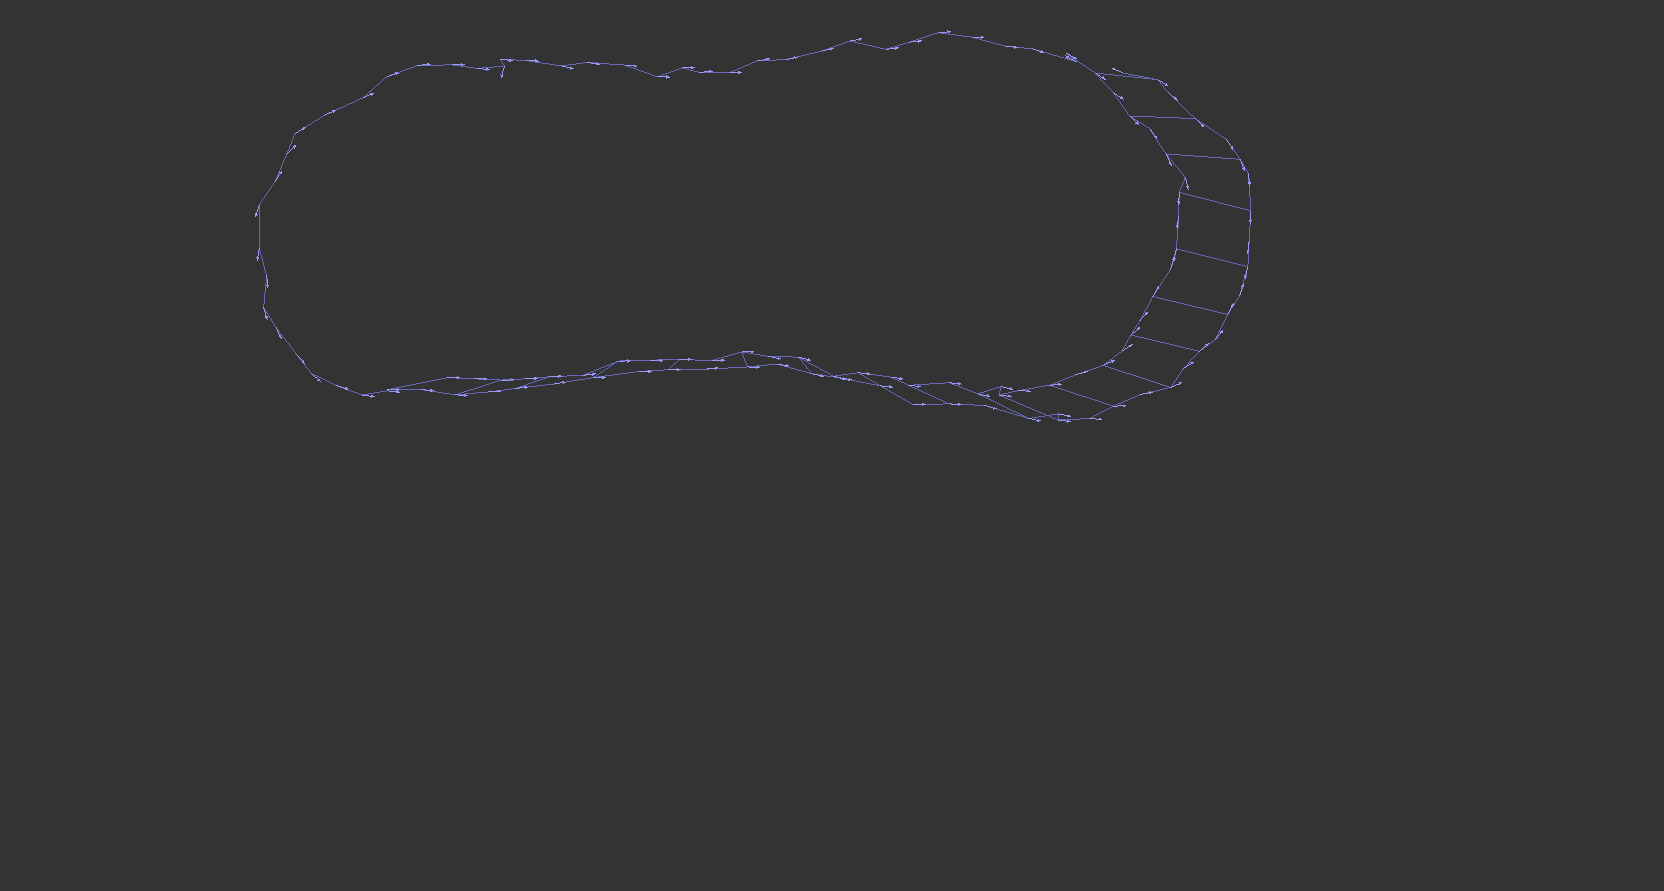




 


#### Optimization of Intel.g2o

(i) Optimzed for 50 iterations. 

(ii) Optimized using gn_var_cholmod
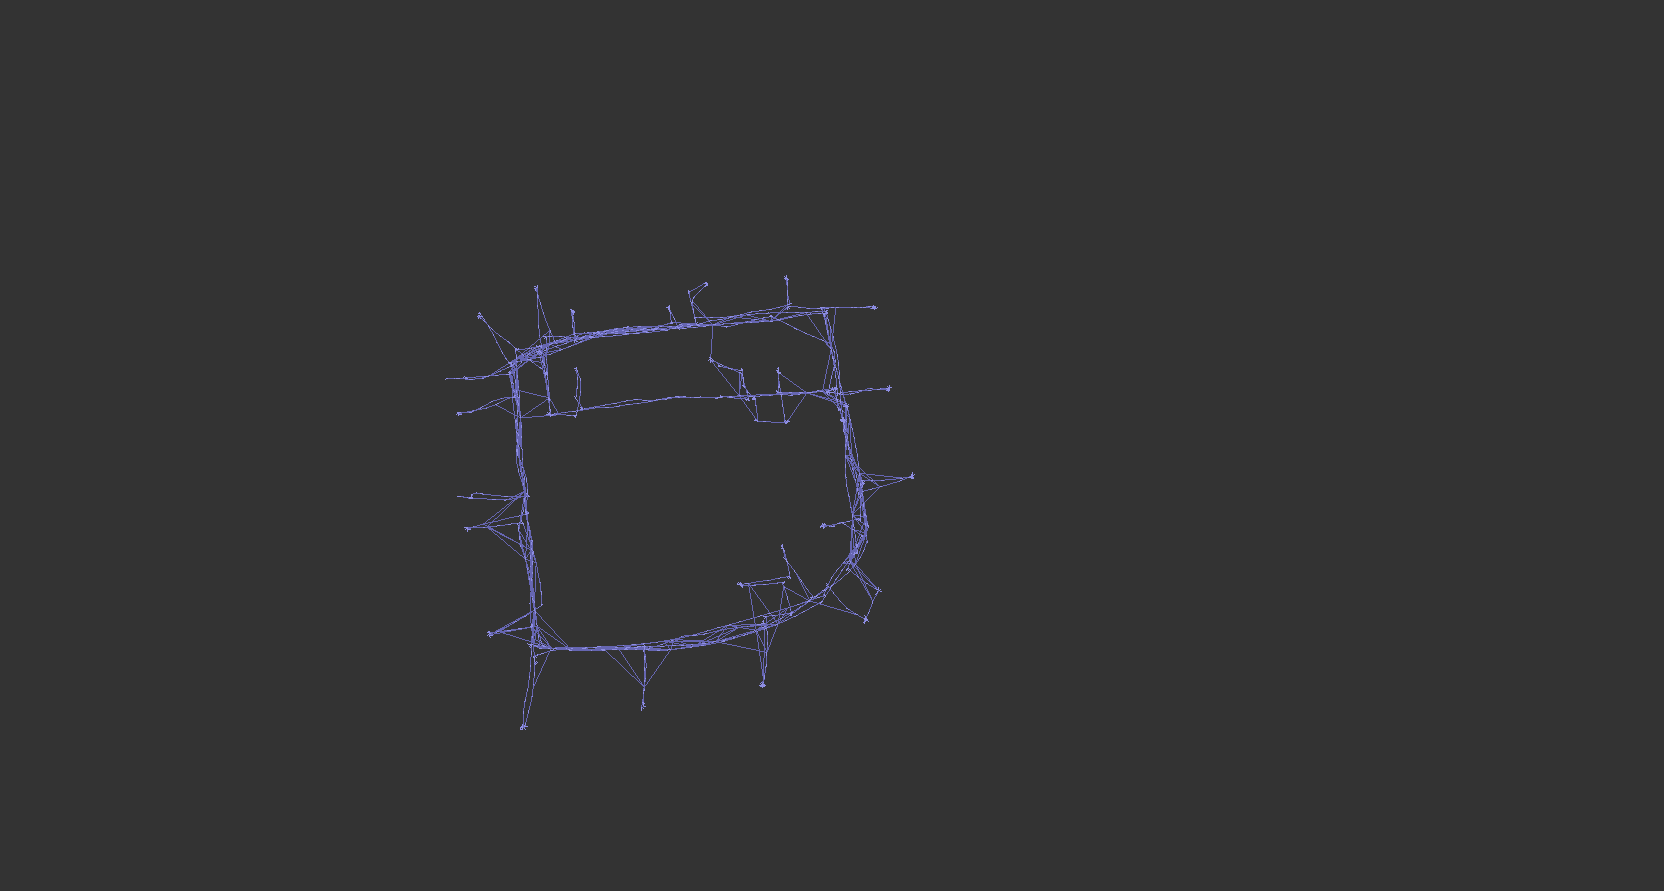

#### Optimization of shere.g2o

1. First experimented without using robust kernel. Obtained a curvature at top, could not optimize further. 

2. Then optimized using **robust kernel(fair)** **with kernel width 0.2.** Did not get a curvature, and the number of iterations were just 100.

4. Increased the number of iterations.
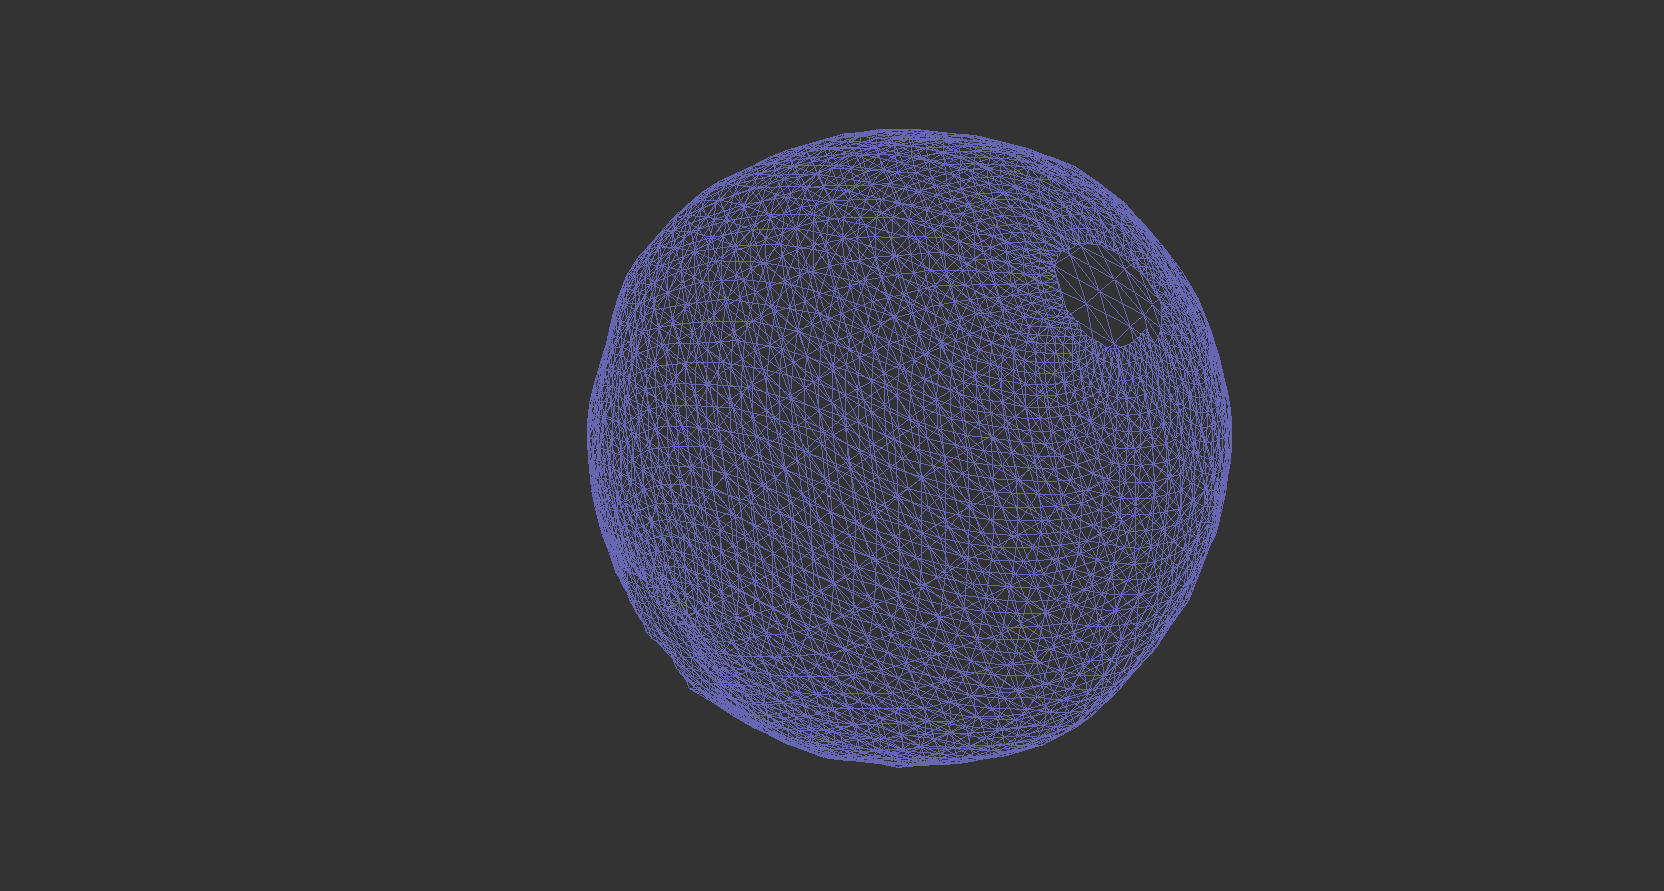

##  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer


Your answer here.

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer

1.
### Summary of Past, Present & Future of SLAM: Towards the Robust Perception Age.
#### Section-IV:Long-Term Autonomy I: Robustess
Failure of a SLAM system can occur either at algorithmic level or at hardware level. The main source of algorithmic errors are the errors occuring during Data association process. The problems that occur during data association are the presence of outliers or false positives. The SLAM system has to deal with challenging environments with limited visibility and constantly changing environment. Other data association problems are related to perceptual aliasing. There are problems associated with short term and long term changes in the environment for SLAM system. SLAM systems designed with the assumption of static environment can only work in small scale environment.

Short term data association is easy to track with camera having sufficient frame rate. Standard procedures like descriptor matching or optical flow can track feautres between consequetive images despite the changes in the environmnet the front end can track and perform short term data associations. Long term data-association involves loop closures detection and validation. The bruteforce approach to loop closure is computationaly intensive as the current image is checked for matching with every other image in the dataset.Bag of words technique quantizes the feature spae and allows more efficient search. Bag of words can give a reliable performance on single precision loop closure but they fail when there are severe illumination variation. This leads to unified representation by using matching sequences and using visual as well as spatial appereances. hese methods reason on the validity of loop closure constraints by looking at the residual error induced by the constraints during optimization. Other methods,instead, attempt to detect outliers a priori, that is, before any optimization takes place, by identifying incorrect loop closures that are not supported by the odometry. The problems associated with robustness can be addressed in the front end or backend of the SLAM system. Some algorithms keep track of changes incured in the dynamic envronment, while main stream techniques do not. Current systems to deal with these problems either maintain multiple maps or have a single representation parameterized by some time-varying parameter.

###### Open Problmes
Current systems are still vulnerable to outliers and regenracies. SLAM systems should have recovery mechanisms to restablish proper operation. A solution to this approach is tighter integration between front end and back end systems of SLAM. 

Malfunctioning of sensor nodes lead to degradation in accuracy. Off-nominal conditions, or aging or if the quality of the sensors do match with noise models used in the back end it will lead to poor estimates. The problem now becomes to resolve the conflicting readings from different sensors. And it is crucial to resolve these problems in saftey-critical applications. 

The current SLAM systems and data association methods(descriptors) or not equipped to work reliably under conditions of day and night 
sequences or between different seasons for metric relocation. Current feature descriptors do not have sufficient invariance to work to work reliably in such circumstances.Spatial
information, inherent to the SLAM problem, such as trajectory
matching, might be exploited to overcome these limitations.
Additionally, mapping with one sensor modality (e.g., 3D
lidar) and localizing in the same map with a different sensor
modality (e.g., camera) can be a useful addition.

SLAM systems are developed only for static and rigid world. Although in the computer vision community and recent non-rigid SFM are able to produce all terrain maps but they are restrictive in thier capabilities. Addressing case of non-rigidity is still a problem which is unexplored. 

SLAM systems need humann input for assigning thresholds that control feature matching RANSAC parameters. But if the SLAM has to work in all kinds of arbitary scenarios, methods of automatic tuning of the invloved parameters needs to be considered. 

#### Section-IV:Long-Term Autonomy II:Scalability

For such applications the size of the
factor graph underlying SLAM can grow unbounded, due to
the continuous exploration of new places and the increasing
time of operation. 

This family of methods addresses scalability by reducing the number of nodes added to the graph, or by including less informative nodes and factors. Use an information-theoretic approach.To add only non-redundant nodes and highly-informative measurements to the graph. 

Another line of work that allows reducing the number of pa-
rameters to be estimated over time is the continuous-time tra-
jectory estimation. the nodes in the factor graph represented the control-points (knots) of the spline which were optimized in a sliding window fashion. This idea has been further improved and optimized by a lot of people, and they are were able to extend it to large scale applications. 

Parallel out-of-core algorithms for SLAM split the computation (and memory) load of factor graph optimization among multiple processors. The key idea is to divide the factor graph into different subgraphs and optimize the overall graph by alternating local optimization of each subgraph, with a global refinement. 

Distributed multi robot SLAM: One way of mapping a large-scale environment is to deploy multiple robots doing SLAM, and divide the scenario in smaller areas, each one mapped by a different robot. This approach has two main variants: the centralized one, where robots build submaps and transfer the local information to a central station that performs inference, and the decentralized one, where there is no central data fusion and the agents leverage local communication to reach consensus on a common map. 

The disadvantage of the using popluar method of Gaussian elemination is that the marginals to be exchanged among the robots are large sized and the communication cost is quadratic in the number of seperators. An alternate approach to Gaussian elimination method is Gauss-Sidel approach which implies a communication burden which is linear in the number of seperators. 


#### Open problems
Despite the work done to reduce the complexity of the factor graph optimization, there have been a lot of aspcets which have been unexplored. 
For example Storage of map/point cloud data or volumetric maps in the memory for extended period of time. While other questions upon which adequete work has not been done are 'How long should a map be remembered or be in the storage?', When should a map be updated and when is a map or data considered to be outdated?. 
Another opend ended problem is rejection of outliers in a distributed robot system. The problems with multi robot system are that they do not share a common frame of reference and they have to detect outliers using partial and local information. Some of the attempts that were made were to timely check and verify the thier location and their prediction of the trajectory at probably at a specified location(rendezvous strategy) before fusing information.
Another problem is to adapt SLAM algorithms in places where severe computational resource constraints exist. This can be seen where the size of the plaotform is scaled down, for example in Mobile phones, micro areial vehicles or robotic insects. Other problems that can arise due to hardwareAnother constraints is the limited bandwidth and communication dropout. And so it would be desirable to have algorithms in which one can tune accuracy with computational load. 


## Describing and Ideating about the Open Problems,
There are a lot of open problems to ideate and think about , keeping the two broad sections in mind - Scalability and Robustness. Let's explore some of the open problems these domains

### Scalability
1. What to learn and what to forget - The open problem is to see how often to update the mapping information. The problem in some level analogous to what caches are meant to do. If an efficient to identify necessary , commonly needed info and only store that while generating other info on demand. 
2. Map representation - During long term mapping , large amount of data is generated. Advanced data compression techniques can help in this to store this data efficiently.
### Robusteness 
1. Slam Recovery - We have established that incorrect measurements are bound to creep up due to localisation problem , we need to have a robust fraud detection system (can use temporal features - previous set of images) to identify whether the input is a valid input or not and reject those below a certaing confidence threshold.
2. Non Dynamic Mapping - The real world is constantly evolving and changing , thus systems to address these are needed. This will require identifying things in a constantly changing environment. A very interesting use case for the same is described in this [paper](https://arxiv.org/abs/1705.05444) which aims to visualise 3d mapping of internal organs.

The following paper represents the map implicitly in a deep convolutional neural network (by training on a proper map i.e. images/views with 6 degree-of-freedom camera pose), and can regress the pose of a novel camera image captured in the same environment. So it can do localization, but would need additional machinery to extend the map. To my surprise, it can capture fairly large scale maps.

http://arxiv.org/pdf/1505.07427.pdf

The following paper learns to do visual odometry with a deep CNN given a couple of nearby frames. Although it doesn't work very well yet, but one can imagine hooking this (perhaps trained with a lot more data?) into something like the LSD-SLAM pipeline to obtain much more robust associations between neighboring frames or a frame with its nearest keyframe, than edges alone can provide.

http://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Agrawal_Learning_to_See_ICCV_2015_paper.pdf

One might also wonder whether there is even a need for explicitly doing SLAM in many applications. For instance, the following latest work by DeepMind is obviously able to understand the environment and navigate within it, without needing any explicit SLAM module. Rather it just learns to navigate in the virtual environment, using a deep reinforcement learning objective. 

Some interesting insights
    Training on a scene-heavy dataset, such as Places by MIT CSAIL, or the Google Street View dataset, improves place recognition performance quite a bit compared to object-heavy sets.

    End-to-end training for place recognition handily beats using pre-trained models focused on classification. It seems that medium-depth representation are quite important here.

    A feed-forward pass through a CNN is much faster than using hand-engineered features, even on a CPU. Interesting speedups for existing SLAM systems seems within easy reach, with the caveat that they need both feature-level and image-level descriptors at the same time.


### Fun section
Check the end of your Project-1 homepage on Notion. :)